**Importing All Necessary Modules and Packages**

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import PIL
import plotly
import plotly.express as px
import gc

import warnings
warnings.filterwarnings("ignore")

**Importing the dataset**

In [2]:
#Locate the file in Personal Machine
path = '/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images'

In [3]:
No_DR_Img = os.listdir(path + '/No_DR/')
Mild_Img = os.listdir(path + '/Mild/')
Moderate_Img = os.listdir(path + '/Moderate/')
Proliferate_DR_Img = os.listdir(path + '/Proliferate_DR/')
Severe_Img = os.listdir(path + '/Severe/')

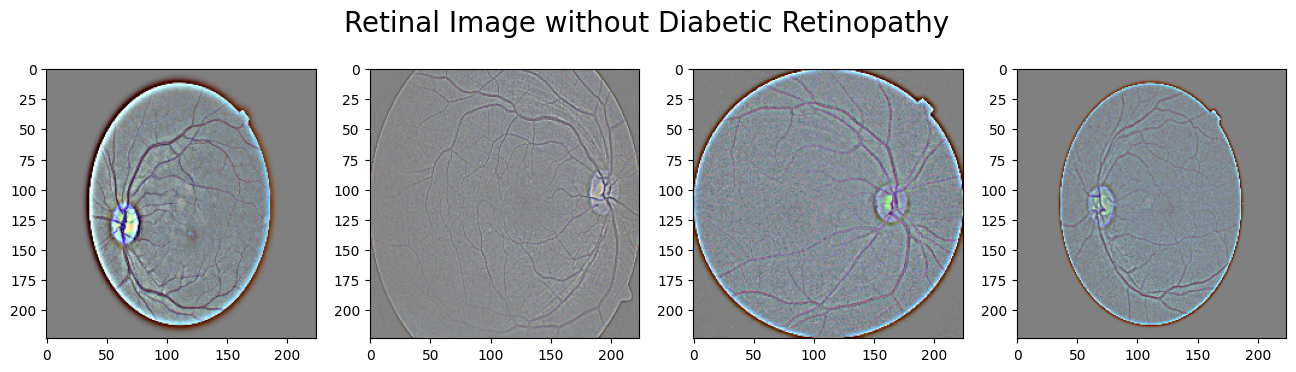

In [4]:
#Viewing the dataset
fig = plt.figure(figsize=(16,4))
for i in range(4):
    plt.subplot(1, 4, i+1)
    img = cv2.imread(path+'/No_DR/'+ No_DR_Img[i])
    plt.imshow(img)
plt.suptitle("Retinal Image without Diabetic Retinopathy",fontsize=20)
plt.show()

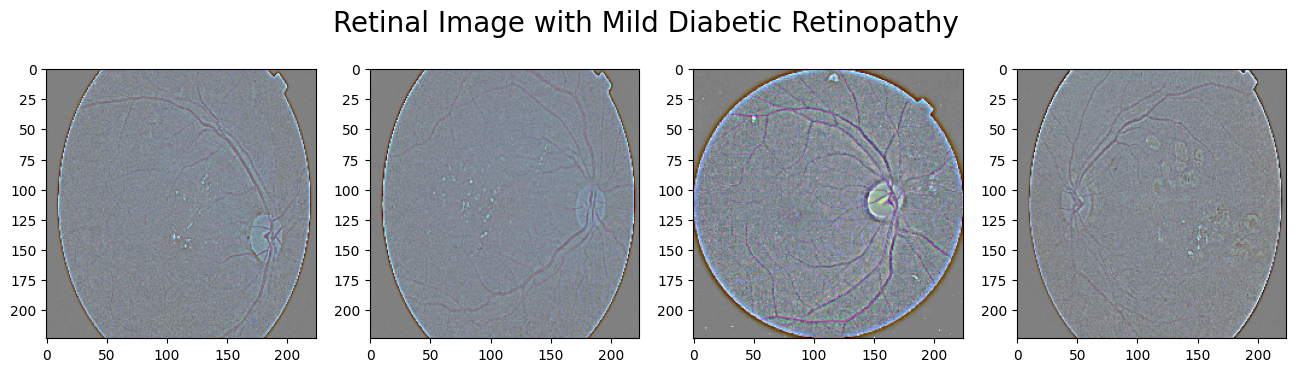

In [5]:
#Viewing the dataset
fig = plt.figure(figsize=(16,4))
for i in range(4):
    plt.subplot(1, 4, i+1)
    img = cv2.imread(path+'/Mild/'+ Mild_Img[i])
    plt.imshow(img)
plt.suptitle("Retinal Image with Mild Diabetic Retinopathy",fontsize=20)
plt.show()

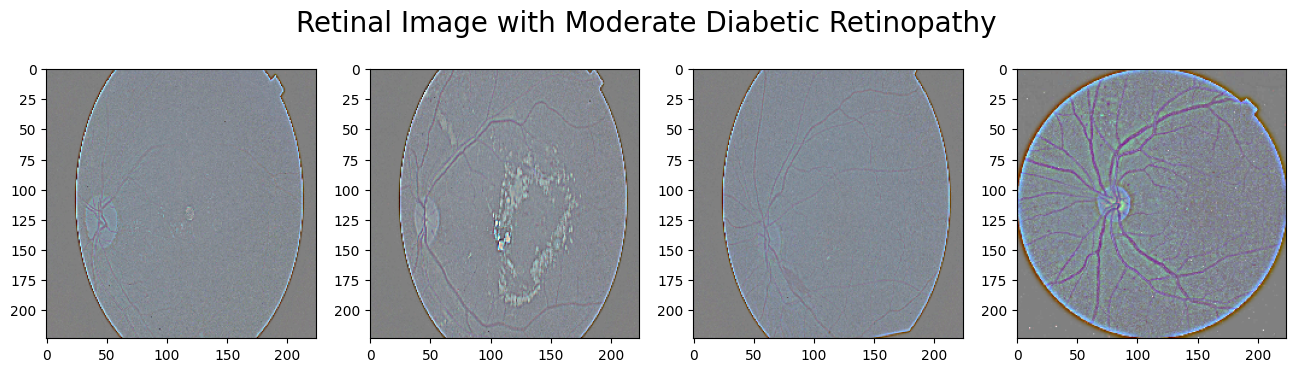

In [6]:
#Viewing the dataset
fig = plt.figure(figsize=(16,4))
for i in range(4):
    plt.subplot(1, 4, i+1)
    img = cv2.imread(path+'/Moderate/'+ Moderate_Img[i])
    plt.imshow(img)
plt.suptitle("Retinal Image with Moderate Diabetic Retinopathy",fontsize=20)
plt.show()

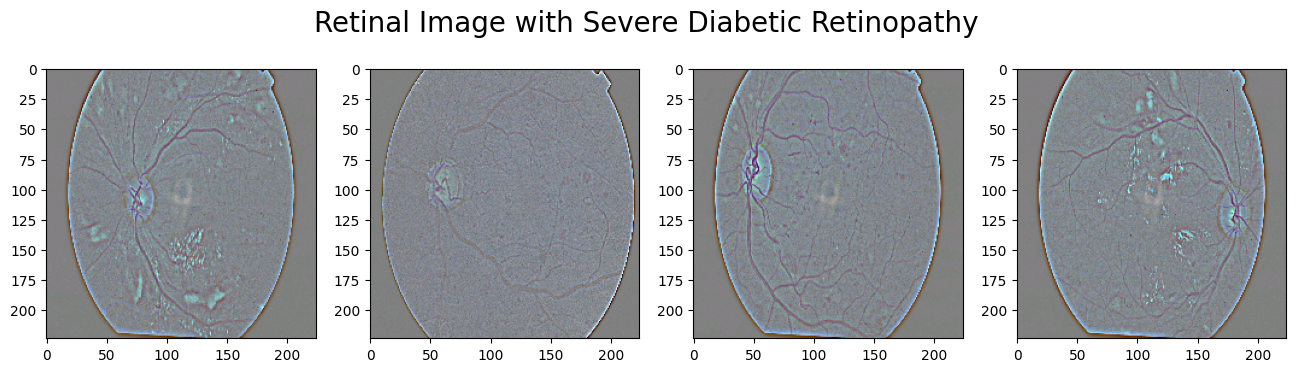

In [7]:
#Viewing the dataset
fig = plt.figure(figsize=(16,4))
for i in range(4):
    plt.subplot(1, 4, i+1)
    img = cv2.imread(path+'/Severe/'+ Severe_Img[i])
    plt.imshow(img)
plt.suptitle("Retinal Image with Severe Diabetic Retinopathy",fontsize=20)
plt.show()

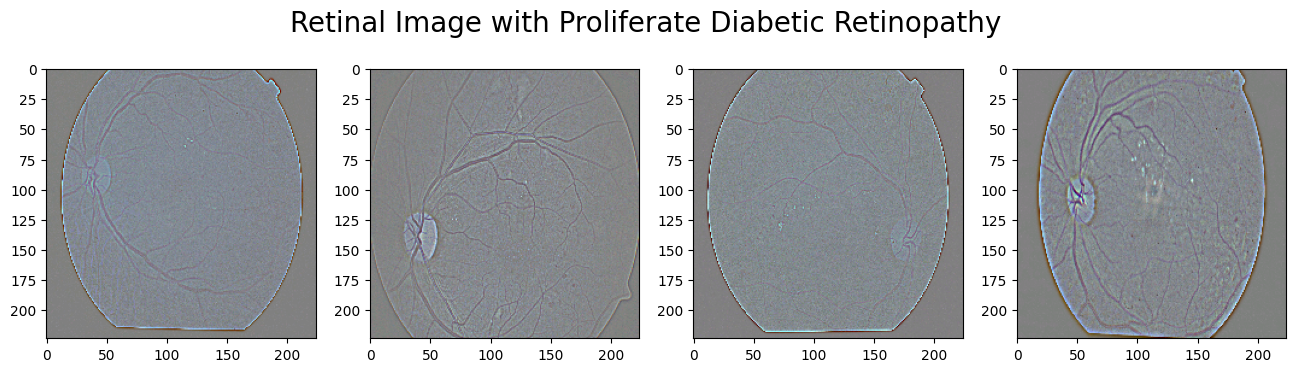

In [8]:
#Viewing the dataset
fig = plt.figure(figsize=(16,4))
for i in range(4):
    plt.subplot(1, 4, i+1)
    img = cv2.imread(path+'/Proliferate_DR/'+ Proliferate_DR_Img[i])
    plt.imshow(img)
plt.suptitle("Retinal Image with Proliferate Diabetic Retinopathy",fontsize=20)
plt.show()

In [16]:
gc.collect()

53996

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchvision.datasets import ImageFolder
import torch.nn.init as init
import os

In [44]:
learning_rate = 0.01
batch_size = 32
num_epochs = 30
weight_decay = 1e-4  # L2 regularization
dropout_rate = 0.5  # Dropout rate for the last FC layer
train_split_ratio = 0.8  # Train-test split ratio

In [12]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [13]:
# Dataset path
data_dir = path


In [38]:
# Training transformations (with augmentations)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.RandomHorizontalFlip(),  # Augmentation
    transforms.RandomRotation(10),  # Augmentation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
])

# Testing transformations (no augmentations)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
])


In [39]:
# Load dataset
dataset = ImageFolder(root=data_dir)  # No transform here initially
train_size = int(train_split_ratio * len(dataset))
test_size = len(dataset) - train_size

# Random split
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Apply transforms to train/test datasets
train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform


# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [40]:
print(f"Total images: {len(dataset)}")
print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(test_dataset)}")
print(f"Classes: {dataset.classes}")

Total images: 3662
Training images: 2929
Validation images: 733
Classes: ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']


In [41]:
# Access a batch from train_loader
images, labels = next(iter(test_loader))
print("Batch shape:", images.shape)  # Output: [batch_size, 3, 224, 224]
print("Labels:", labels)             # Output: Tensor of labels


Batch shape: torch.Size([64, 3, 224, 224])
Labels: tensor([1, 2, 1, 2, 3, 1, 0, 2, 4, 2, 2, 1, 1, 2, 2, 1, 3, 2, 1, 2, 2, 2, 4, 3,
        3, 2, 0, 2, 2, 2, 2, 3, 1, 2, 3, 2, 2, 1, 0, 2, 1, 2, 1, 2, 2, 2, 2, 2,
        2, 2, 3, 2, 2, 2, 1, 1, 2, 2, 1, 1, 4, 0, 0, 0])


# **Import the Model Architecture (ResNet18)**

In [42]:
# Load ResNet18 model
resnet18 = models.resnet18(pretrained=True)

# Freeze all layers except the last fully connected layer
for param in resnet18.parameters():
    param.requires_grad = False

# Modify the final layer
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Sequential(
    nn.Dropout(dropout_rate),  # Add dropout for regularization
    nn.Linear(num_ftrs, len(dataset.classes))  # Replace output layer with the number of classes
)

# Initialize weights for the last layer
def weights_init(m):
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)

resnet18.fc.apply(weights_init)

# Move model to device
resnet18 = resnet18.to(device)

In [43]:
# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(resnet18.fc.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training and evaluation history
history = {
    'train_loss': [],
    'train_accuracy': [],
    'test_loss': [],
    'test_accuracy': []
}

In [45]:
# Training loop
for epoch in range(num_epochs):
    # Training phase
    resnet18.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = resnet18(inputs)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Update metrics
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)
    
    # Calculate train loss and accuracy
    train_loss = running_loss / total_samples
    train_accuracy = correct_predictions / total_samples
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_accuracy)

    # Evaluation phase
    resnet18.eval()
    test_loss = 0.0
    test_correct_predictions = 0
    test_total_samples = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet18(inputs)
            loss = criterion(outputs, labels)

            # Update metrics
            test_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            test_correct_predictions += (preds == labels).sum().item()
            test_total_samples += labels.size(0)
    
    # Calculate test loss and accuracy
    test_loss /= test_total_samples
    test_accuracy = test_correct_predictions / test_total_samples
    history['test_loss'].append(test_loss)
    history['test_accuracy'].append(test_accuracy)

    # Update learning rate
    scheduler.step()

    # Print epoch statistics
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")



Epoch [1/30], Train Loss: 1.1060, Train Accuracy: 0.6057, Test Loss: 0.8626, Test Accuracy: 0.7040
Epoch [2/30], Train Loss: 0.8726, Train Accuracy: 0.6924, Test Loss: 0.7808, Test Accuracy: 0.7285
Epoch [3/30], Train Loss: 0.7992, Train Accuracy: 0.7180, Test Loss: 0.7565, Test Accuracy: 0.7190
Epoch [4/30], Train Loss: 0.7427, Train Accuracy: 0.7303, Test Loss: 0.7464, Test Accuracy: 0.7353
Epoch [5/30], Train Loss: 0.7106, Train Accuracy: 0.7398, Test Loss: 0.7180, Test Accuracy: 0.7517
Epoch [6/30], Train Loss: 0.7037, Train Accuracy: 0.7402, Test Loss: 0.7409, Test Accuracy: 0.7299
Epoch [7/30], Train Loss: 0.6962, Train Accuracy: 0.7463, Test Loss: 0.7473, Test Accuracy: 0.7340
Epoch [8/30], Train Loss: 0.6608, Train Accuracy: 0.7593, Test Loss: 0.7534, Test Accuracy: 0.7326
Epoch [9/30], Train Loss: 0.6632, Train Accuracy: 0.7583, Test Loss: 0.7004, Test Accuracy: 0.7394
Epoch [10/30], Train Loss: 0.6328, Train Accuracy: 0.7665, Test Loss: 0.7039, Test Accuracy: 0.7435
Epoch [11

In [46]:
# Retrieve the history for the best configuration
# best_history = results[best_config]

# Extract the training and test metrics
best_train_loss = history['train_loss'][-1]
best_train_accuracy = history['train_accuracy'][-1]
best_test_loss = history['test_loss'][-1]
best_test_accuracy = history['test_accuracy'][-1]

# Print the metrics
print("Best Configuration Metrics:")
print("Training Loss:", best_train_loss)
print("Training Accuracy:", best_train_accuracy)
print("Test Loss:", best_test_loss)
print("Test Accuracy:", best_test_accuracy)


Best Configuration Metrics:
Training Loss: 0.6074977797752112
Training Accuracy: 0.7787640833048822
Test Loss: 0.6859349362033776
Test Accuracy: 0.747612551159618


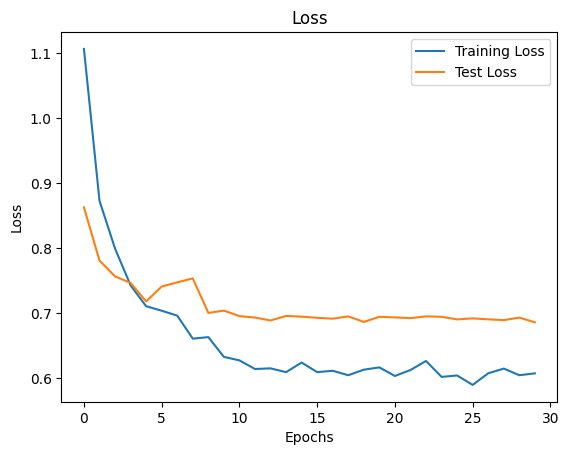

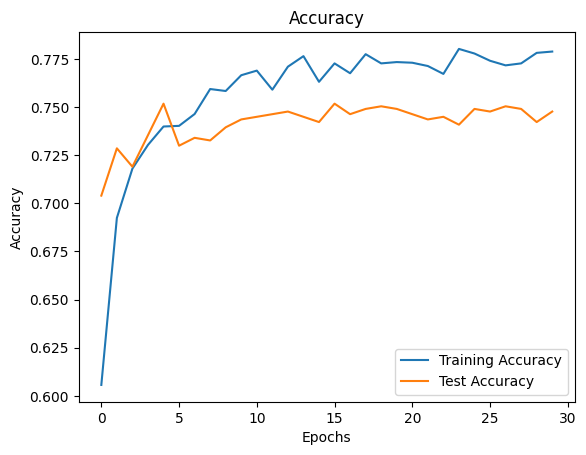

In [47]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    train_loss = history['train_loss']
    test_loss = history['test_loss']
    train_accuracy = history['train_accuracy']
    test_accuracy = history['test_accuracy']

    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(test_loss, label='Test Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure()
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(test_accuracy, label='Test Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Call the plot_metrics function with the history of the best configuration
plot_metrics(history)


In [48]:
import torch
import torchvision.transforms as transforms
from PIL import Image

def predict_image_class(img_path, model, class_labels):
    # Load the image
    img = Image.open(img_path)

    # Define transformations to apply to the image
    transform = transforms.Compose([
        transforms.Resize((128, 128)),  # Resize to match the input size of your model
        transforms.ToTensor(),           # Convert to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet mean and std
    ])

    # Apply transformations to the image
    img_tensor = transform(img)
    img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension

    # Move the tensor to the appropriate device (e.g., GPU if available)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    img_tensor = img_tensor.to(device)

    # Set the model to evaluation mode
    model.eval()

    # Perform inference
    with torch.no_grad():
        outputs = model(img_tensor)

    # Convert the output probabilities to predicted class label
    predicted_class_index = torch.argmax(outputs).item()

    # Map predicted class index to class label
    predicted_class_label = class_labels[predicted_class_index]

    return predicted_class_label

# Example usage:
# Assuming `resnet18` is your pre-trained model and `class_labels` is a list of class labels
img_path = '/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Mild/12ce6a1a1f31.png'
predicted_label = predict_image_class(img_path, resnet18, ['Mild', 'Moderate','No', 'Proliferate', 'Severe'])
print("Predicted class label:", predicted_label)


Predicted class label: No


# hyperparameter Tuning

In [49]:
class DiabeticRetinopathyCNN(nn.Module):
    def __init__(self, input_channels=3, num_classes=5, num_hidden_layers=2, neurons_per_layer=128, dropout_rate=0.3):
        super(DiabeticRetinopathyCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

        # Dynamically created fully connected layers
        fc_layers = []
        input_dim = 512 * 14 * 14  # Adjust based on input image size

        for _ in range(num_hidden_layers):
            fc_layers.append(nn.Linear(input_dim, neurons_per_layer))
            fc_layers.append(nn.ReLU())
            fc_layers.append(nn.Dropout(dropout_rate))
            input_dim = neurons_per_layer

        self.fc_layers = nn.Sequential(*fc_layers)

        # Output layer
        self.output = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))

        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        x = self.output(x)
        return x


In [29]:
def objective(trial):
    # Hyperparameter search space
    num_hidden_layers = trial.suggest_int("num_hidden_layers", 4, 10)
    neurons_per_layer = trial.suggest_int("neurons_per_layer", 32, 512, step=32)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ['Adam', 'SGD', 'RMSprop'])
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    epochs = trial.suggest_int("epochs", 10, 100, step=10)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)

    # Dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    # Model initialization
    input_channels = 3  # Assuming RGB images
    num_classes = 5     # Assuming 5 output classes
    model = DiabeticRetinopathyCNN(
        input_channels=input_channels,
        num_classes=num_classes,
        num_hidden_layers=num_hidden_layers,
        neurons_per_layer=neurons_per_layer,
        dropout_rate=dropout_rate
    ).to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    else:
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Training loop
    model.train()
    for epoch in range(epochs):
        for batch_features, batch_labels in train_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for batch_features, batch_labels in test_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            outputs = model(batch_features)
            _, predicted = torch.max(outputs, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()

    accuracy = correct / total
    return accuracy


In [30]:
!pip install optuna

In [31]:
import optuna

study = optuna.create_study(direction='maximize')

[I 2025-01-18 04:38:11,710] A new study created in memory with name: no-name-e87bc11a-4f77-4abc-b899-a8951291b99c


In [ ]:
study.optimize(objective, n_trials=10)

In [33]:
study.best_value

0.7598908594815825

In [34]:
study.best_params

{'num_hidden_layers': 6,
 'neurons_per_layer': 32,
 'dropout_rate': 0.2,
 'learning_rate': 0.0014688149860685336,
 'optimizer': 'Adam',
 'batch_size': 64,
 'epochs': 70,
 'weight_decay': 0.0002449641025717929}

In [36]:
# Get the best parameters from the Optuna study
best_params = study.best_trial.params
print("Best Parameters:", best_params)


Best Parameters: {'num_hidden_layers': 6, 'neurons_per_layer': 32, 'dropout_rate': 0.2, 'learning_rate': 0.0014688149860685336, 'optimizer': 'Adam', 'batch_size': 64, 'epochs': 70, 'weight_decay': 0.0002449641025717929}


In [50]:
# Extract hyperparameters
num_hidden_layers = best_params["num_hidden_layers"]
neurons_per_layer = best_params["neurons_per_layer"]
dropout_rate = best_params["dropout_rate"]
learning_rate = best_params["learning_rate"]
optimizer_name = best_params["optimizer"]
batch_size = best_params["batch_size"]
epochs = best_params["epochs"]
weight_decay = best_params["weight_decay"]

# Dataloader for final training
final_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
final_test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

# Initialize model with best hyperparameters
final_model = DiabeticRetinopathyCNN(
    input_channels=3,
    num_classes=5,
    num_hidden_layers=num_hidden_layers,
    neurons_per_layer=neurons_per_layer,
    dropout_rate=dropout_rate
).to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
if optimizer_name == 'Adam':
    optimizer = optim.Adam(final_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
elif optimizer_name == 'SGD':
    optimizer = optim.SGD(final_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
else:
    optimizer = optim.RMSprop(final_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training loop
final_model.train()
for epoch in range(epochs):
    for batch_features, batch_labels in final_train_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        optimizer.zero_grad()
        outputs = final_model(batch_features)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs} completed.")

# Final evaluation
final_model.eval()
total = 0
correct = 0
with torch.no_grad():
    for batch_features, batch_labels in final_test_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        outputs = final_model(batch_features)
        _, predicted = torch.max(outputs, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

final_accuracy = correct / total
print(f"Final Model Accuracy: {final_accuracy * 100:.2f}%")


Epoch 1/70 completed.
Epoch 2/70 completed.
Epoch 3/70 completed.
Epoch 4/70 completed.
Epoch 5/70 completed.
Epoch 6/70 completed.
Epoch 7/70 completed.
Epoch 8/70 completed.
Epoch 9/70 completed.
Epoch 10/70 completed.
Epoch 11/70 completed.
Epoch 12/70 completed.
Epoch 13/70 completed.
Epoch 14/70 completed.
Epoch 15/70 completed.
Epoch 16/70 completed.
Epoch 17/70 completed.
Epoch 18/70 completed.
Epoch 19/70 completed.
Epoch 20/70 completed.
Epoch 21/70 completed.
Epoch 22/70 completed.
Epoch 23/70 completed.
Epoch 24/70 completed.
Epoch 25/70 completed.
Epoch 26/70 completed.
Epoch 27/70 completed.
Epoch 28/70 completed.
Epoch 29/70 completed.
Epoch 30/70 completed.
Epoch 31/70 completed.
Epoch 32/70 completed.
Epoch 33/70 completed.
Epoch 34/70 completed.
Epoch 35/70 completed.
Epoch 36/70 completed.
Epoch 37/70 completed.
Epoch 38/70 completed.
Epoch 39/70 completed.
Epoch 40/70 completed.
Epoch 41/70 completed.
Epoch 42/70 completed.
Epoch 43/70 completed.
Epoch 44/70 complete

In [51]:
# Save the model
torch.save(resnet18, '/kaggle/working/resnet18_model.pth')

# Print the path to the saved model
print("Model saved at:", '/kaggle/working/resnet18_model.pth')


Model saved at: /kaggle/working/resnet18_model.pth
